In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import cmcrameri.cm as cmc
import colorcet as cc

import bemcs



In [2]:
COEFFICIENT_OF_FRICTION = 0.6
Y_AMPLITUDE = 0.2

In [3]:
# flag for slip to be purely shear
slip_purely_shear = True

fault_length = 1.5  # fault length in x

# Specify amplitude and number of wavelengths for sinusoidal fault geometry
# y_amplitude = 0.01
lambda_cycles = 1.0

# Elastic parameters
mu = 1
nu = 0.25
n_obs = 200
width = 1.5
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width / 2, width / 2, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Low resolution fault mesh

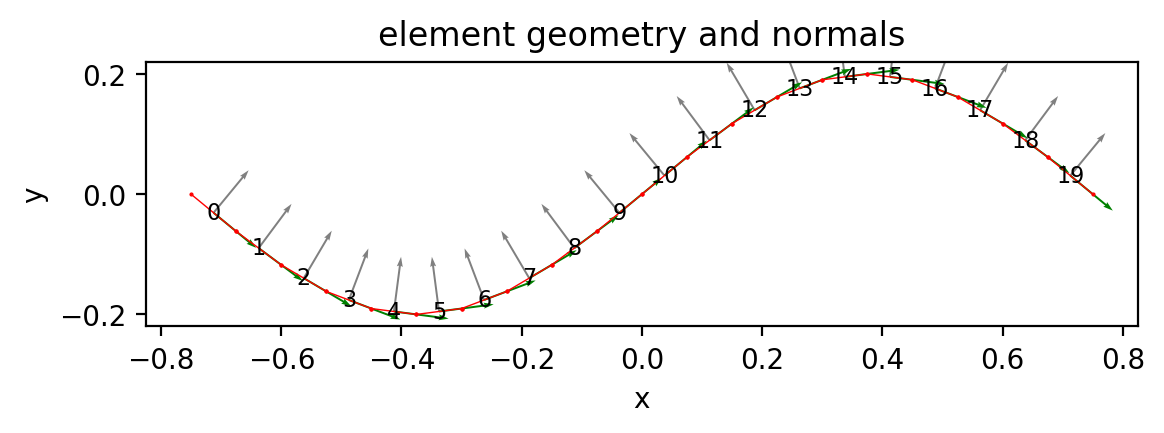

In [4]:
# Use a non-uniform mesh
n_els = 20

# Sinusoidal y-positions for fault elements
sorted_xlocs = np.linspace(
    -fault_length / 2 + fault_length / n_els,
    fault_length / 2 - fault_length / n_els,
    n_els - 1,
)

# Wavy fault geometry
x1 = np.concatenate((np.array([-fault_length / 2.0]), sorted_xlocs))
x2 = np.concatenate((sorted_xlocs, np.array([fault_length / 2.0])))
y1 = Y_AMPLITUDE * np.sin(lambda_cycles * 2 * np.pi * x1 / fault_length)
y2 = Y_AMPLITUDE * np.sin(lambda_cycles * 2 * np.pi * x2 / fault_length)
els = bemcs.initialize_els()
els.x1 = np.copy(x1)
els.y1 = np.copy(y1)
els.x2 = np.copy(x2)
els.y2 = np.copy(y2)
bemcs.standardize_els_geometry(els)
bemcs.plot_els_geometry(els)

Forcing slip vector at patch centers to be purely shear


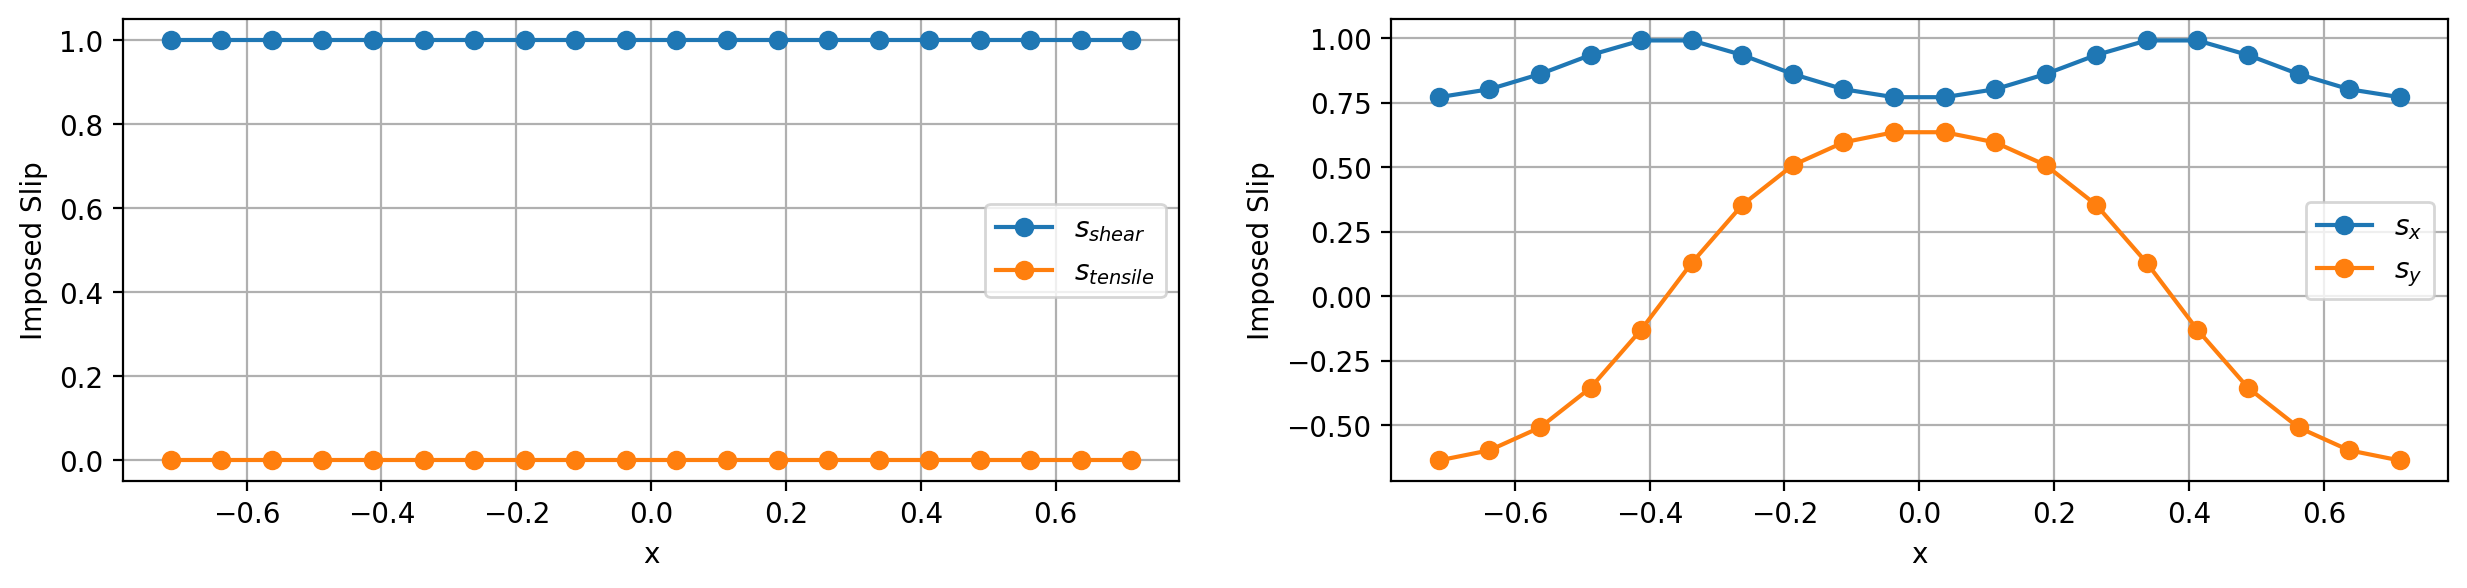

In [5]:
# Slip imposed at central nodes of each patch (these are in x,y coordinates)
# slip_values = np.exp(-((np.linspace(-1, 1, n_els)) ** 2) / 2 / (0.5**2))
slip_values = np.ones(n_els)

slip_vector_x = np.zeros_like(slip_values)
slip_vector_y = np.zeros_like(slip_values)
slip_vector_s = np.zeros_like(slip_values)
slip_vector_n = np.zeros_like(slip_values)

# Force slip vector to be purely shear (s_n = 0)
if slip_purely_shear == True:
    slip_vector_s = slip_values
    slip_vector_n = np.zeros_like(slip_vector_s)
    slip_vector = np.vstack((slip_vector_s, slip_vector_n)).T
    print("Forcing slip vector at patch centers to be purely shear")
    for i in range(n_els):
        slip_vector_x[i], slip_vector_y[i] = (
            slip_vector[i, :] @ els.rot_mats_inv[i, :, :]
        )
else:
    slip_vector_x = slip_values
    slip_vector_y = np.zeros_like(slip_vector_x)
    slip_vector = np.vstack((slip_vector_x, slip_vector_y)).T
    for i in range(n_els):
        slip_vector_s[i], slip_vector_n[i] = (
            slip_vector[i, :] @ els.rot_mats_inv[i, :, :]
        )
# plot slip function
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(els.x_centers, slip_vector_s, "o-", label="$s_{shear}$")
plt.plot(els.x_centers, slip_vector_n, "o-", label="$s_{tensile}$")
plt.xlabel("x")
plt.ylabel("Imposed Slip")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(els.x_centers, slip_vector_x, "o-", label="$s_x$")
plt.plot(els.x_centers, slip_vector_y, "o-", label="$s_y$")
plt.xlabel("x")
plt.ylabel("Imposed Slip")
plt.grid()
plt.legend()
plt.show()

In [6]:
# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride))
bc_vec[0:2] = 0.0
bc_vec[-2:] = 0.0
bc_vec[2::stride] = slip_vector_x
bc_vec[3::stride] = slip_vector_y

# Populate design matrix
# Boundary nodes
design_mat[0:2, :] = slip_mat[0:2]
design_mat[-2:, :] = slip_mat[-2:, :]

# Patch center nodes
design_mat[2::stride, :] = slip_mat[2::stride, :]
design_mat[3::stride, :] = slip_mat[3::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity (x component)
design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

# Slip continuity (x component)
design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

# Smoothness
# x component
design_mat[6:-5:stride, :] = (
    slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
)
# y component
design_mat[7:-4:stride, :] = (
    slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(design_mat) @ bc_vec

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

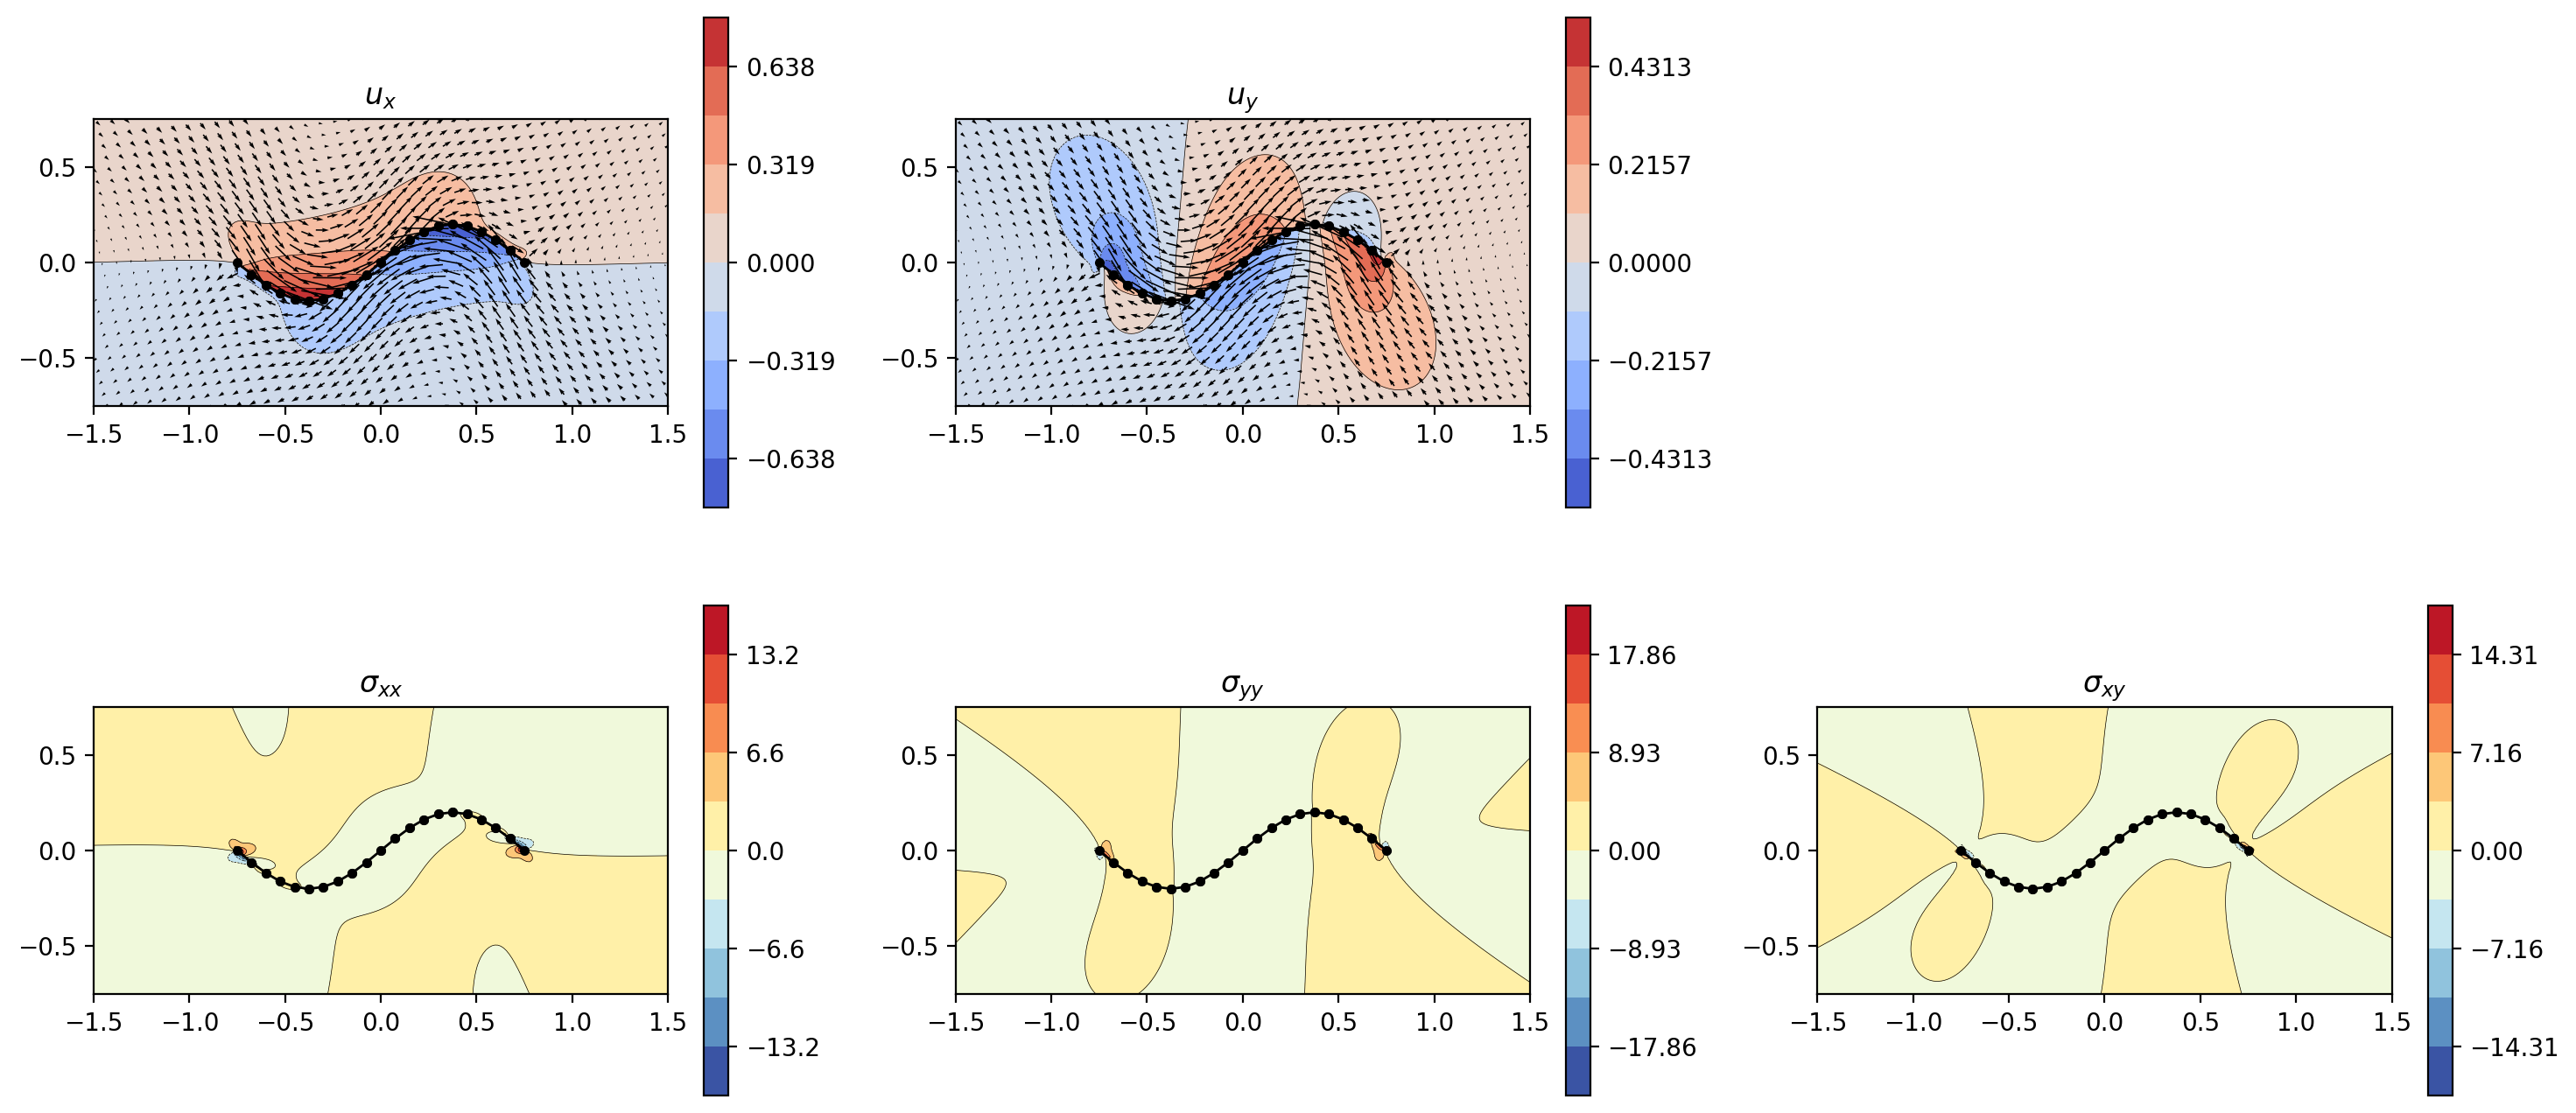

In [7]:
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)

# constant slip kernels
kernels_s_true_constant = bemcs.get_displacement_stress_kernel_constant(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
ux_constant = kernels_s_true_constant[3] @ slip_vector_s
uy_constant = kernels_s_true_constant[4] @ slip_vector_s
sxx_constant = kernels_s_true_constant[0] @ slip_vector_s
syy_constant = kernels_s_true_constant[1] @ slip_vector_s
sxy_constant = kernels_s_true_constant[2] @ slip_vector_s

n_skip_plot = 41  # plotting for vectors
bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot
)

In [16]:
# Calculate second invariant of stress tensor
second_invariant_lowres = sxx * syy - sxy**2.0
second_invariant_lowres_constant = sxx_constant * syy_constant - sxy_constant**2.0

# Calculate Coulomb failure stress
cfs_lowres = sxy - COEFFICIENT_OF_FRICTION * syy
cfs_lowres_constant = sxy - COEFFICIENT_OF_FRICTION * syy_constant

# Calculate velocity magnitude
u_mag = np.sqrt(ux**2.0 + uy**2.0)
u_mag_constant = np.sqrt(ux_constant**2.0 + uy_constant**2.0)

# Calculate strain energy
strain_energy = bemcs.get_strain_from_stress(
    sxx, syy, sxy, mu, nu, conversion="plane_strain"
)

strain_energy_constant = bemcs.get_strain_from_stress(
    sxx_constant, syy_constant, sxy_constant, mu, nu, conversion="plane_strain"
)

conversion='plane_strain'
[[ 0.375 -0.125  0.   ]
 [-0.125  0.375  0.   ]
 [ 0.     0.     1.   ]]
conversion='plane_strain'
[[ 0.375 -0.125  0.   ]
 [-0.125  0.375  0.   ]
 [ 0.     0.     1.   ]]


# Plot second stress invariant

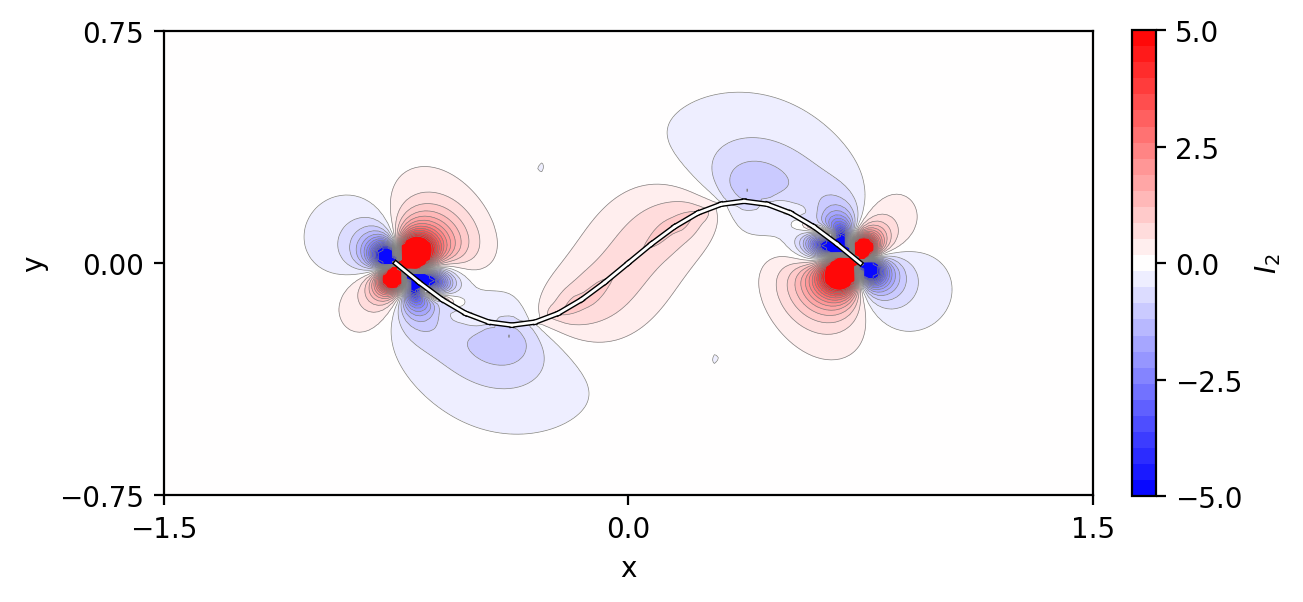

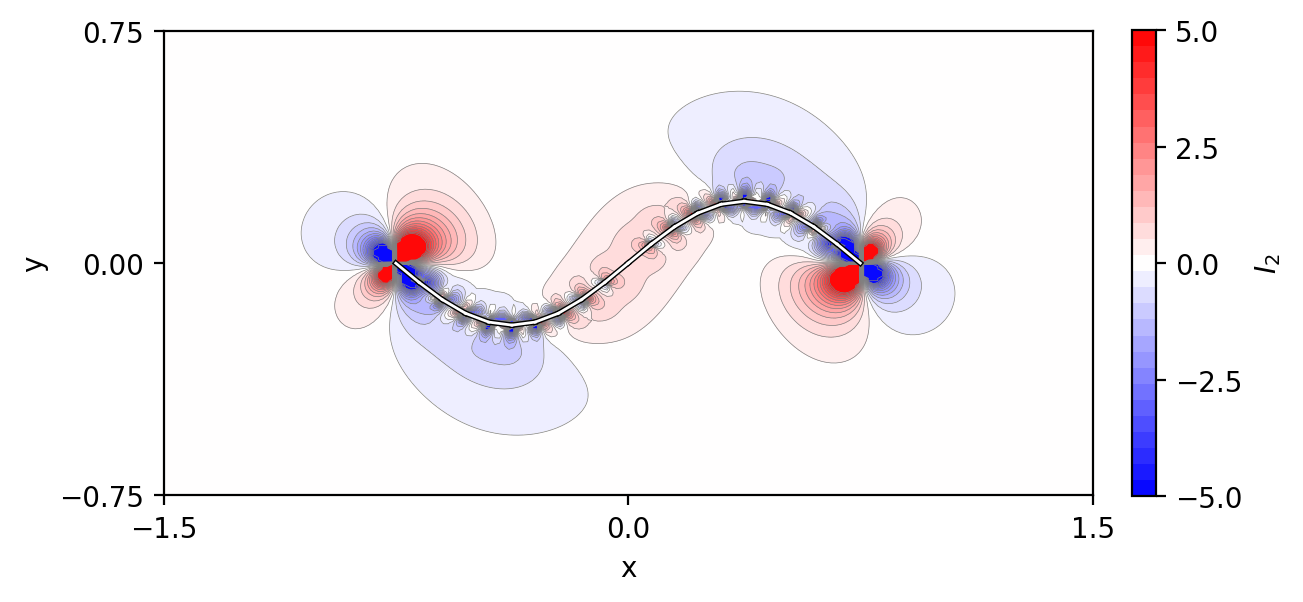

In [14]:
def plot_i2_stress(x_obs, y_obs, n_obs, els, toplot, plotmax=2):
    min_val = -plotmax
    max_val = plotmax
    n_els = np.size(els.x1)
    toplot[toplot < min_val] = min_val
    toplot[toplot > max_val] = max_val

    levels = np.linspace(min_val, max_val, 30)
    plt.contourf(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot.reshape(n_obs, n_obs),
        cmap="bwr",
        levels=levels,
    )
    plt.colorbar(
        fraction=0.0235,
        pad=0.04,
        label="$I_2$",
        ticks=np.linspace(min_val, max_val, 5),
        extend="both",
    )
    plt.contour(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot.reshape(n_obs, n_obs),
        linewidths=0.25,
        colors="gray",
        linestyles="-",
        levels=levels,
    )

    for i in range(n_els):
        plt.plot(
            [els.x1[i], els.x2[i]],
            [els.y1[i], els.y2[i]],
            "-k",
            linewidth=2.0,
        )
    for i in range(n_els):
        plt.plot(
            [els.x1[i], els.x2[i]],
            [els.y1[i], els.y2[i]],
            "-w",
            linewidth=1.0,
        )

    plt.xlim([np.min(x_obs), np.max(x_obs)])
    plt.ylim([np.min(y_obs), np.max(y_obs)])
    plt.xticks([-1.5, 0.0, 1.5])
    plt.yticks([-0.75, 0.0, 0.75])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()


plot_i2_stress(x_obs, y_obs, n_obs, els, second_invariant_lowres, plotmax=5)
plot_i2_stress(x_obs, y_obs, n_obs, els, second_invariant_lowres_constant, plotmax=5)

# Plot Coulomb failure stress for low res and high res faults


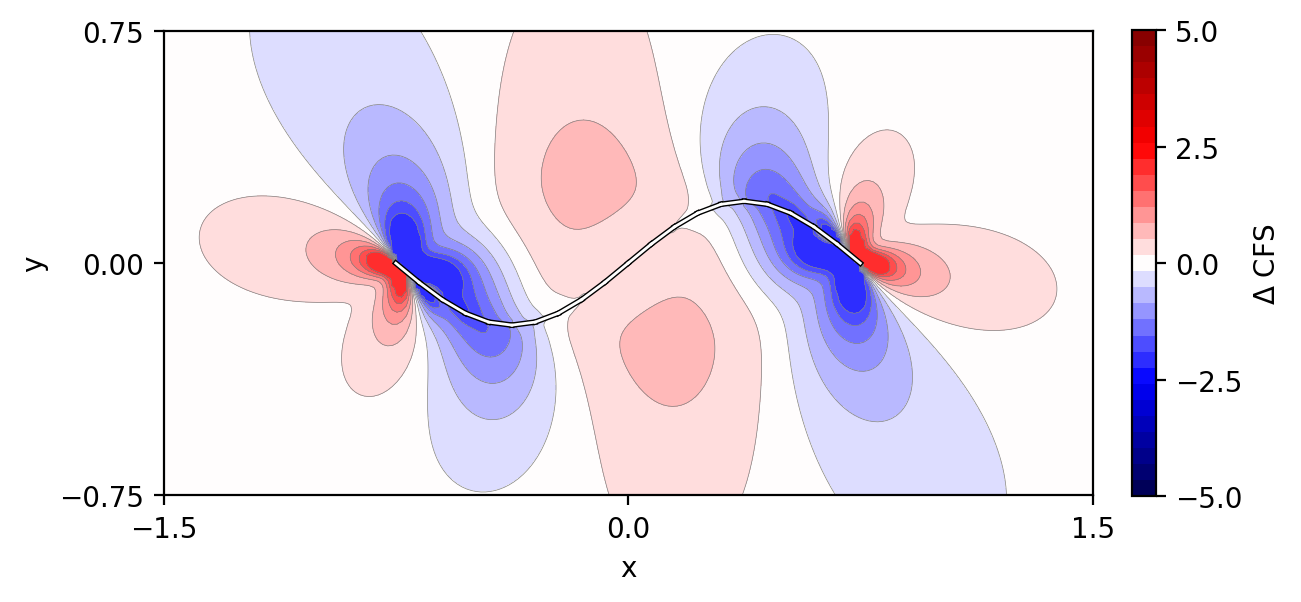

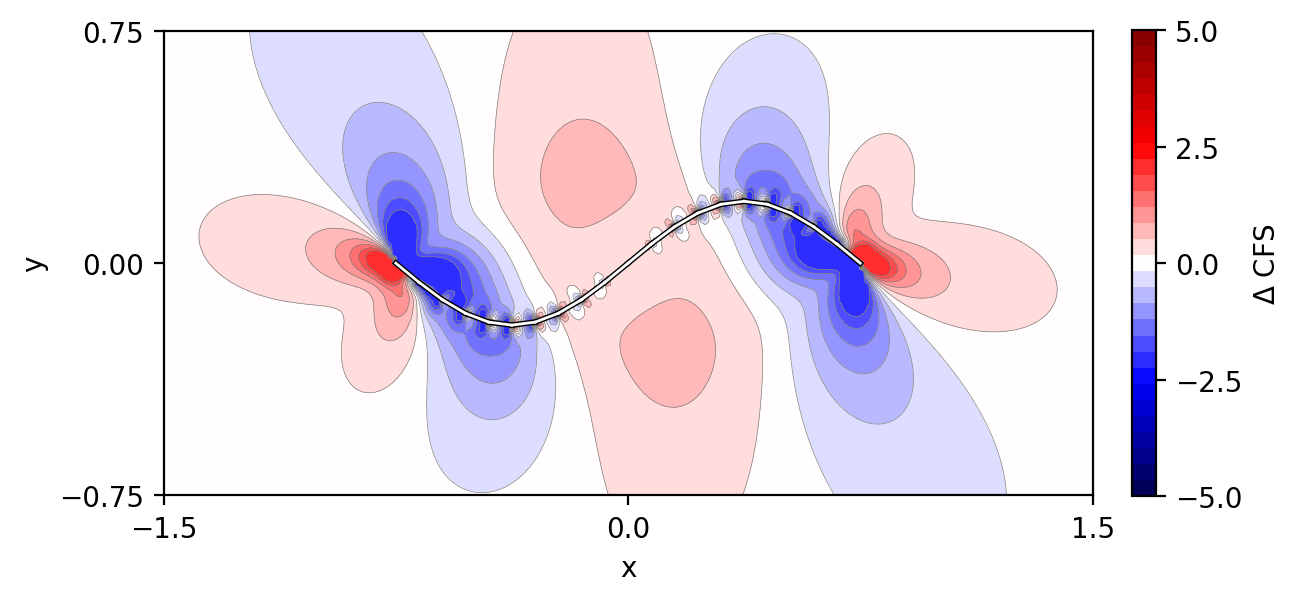

In [15]:
def plot_cfs(x_obs, y_obs, n_obs, els, toplot, plotmax=2):
    min_val = -plotmax
    max_val = plotmax
    n_els = np.size(els.x1)
    toplot[toplot < min_val] = min_val
    toplot[toplot > max_val] = max_val

    levels = np.linspace(min_val, max_val, 30)
    plt.contourf(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot.reshape(n_obs, n_obs),
        # cmap=cmc.bam,
        # cmap=cc.cm.CET_R1,
        cmap="seismic",
        levels=levels,
    )
    plt.colorbar(
        fraction=0.0235,
        pad=0.04,
        label="$\Delta$ CFS",
        ticks=np.linspace(min_val, max_val, 5),
        extend="both",
    )
    plt.contour(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot.reshape(n_obs, n_obs),
        linewidths=0.25,
        colors="gray",
        linestyles="-",
        levels=levels,
    )

    for i in range(n_els):
        plt.plot(
            [els.x1[i], els.x2[i]],
            [els.y1[i], els.y2[i]],
            "-k",
            linewidth=2.0,
        )
    for i in range(n_els):
        plt.plot(
            [els.x1[i], els.x2[i]],
            [els.y1[i], els.y2[i]],
            "-w",
            linewidth=1.0,
        )

    plt.xlim([np.min(x_obs), np.max(x_obs)])
    plt.ylim([np.min(y_obs), np.max(y_obs)])
    plt.xticks([-1.5, 0.0, 1.5])
    plt.yticks([-0.75, 0.0, 0.75])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()


plot_cfs(x_obs, y_obs, n_obs, els, cfs_lowres, plotmax=5)
plot_cfs(x_obs, y_obs, n_obs, els, cfs_lowres_constant, plotmax=5)

# Plot velocity magnitudes

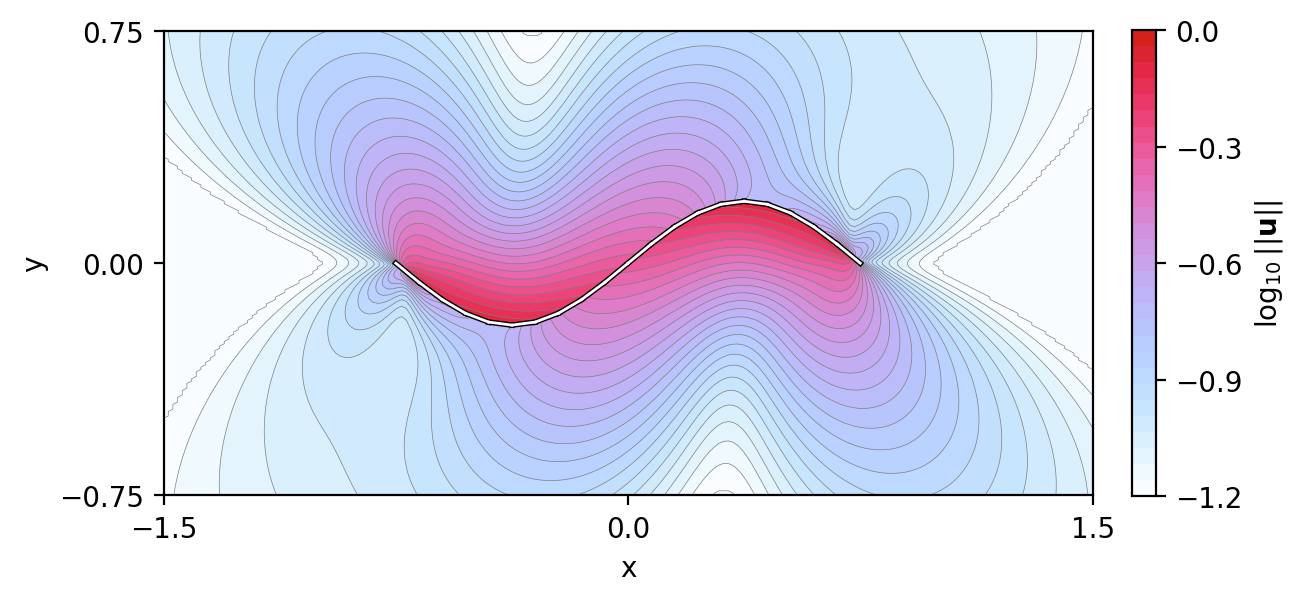

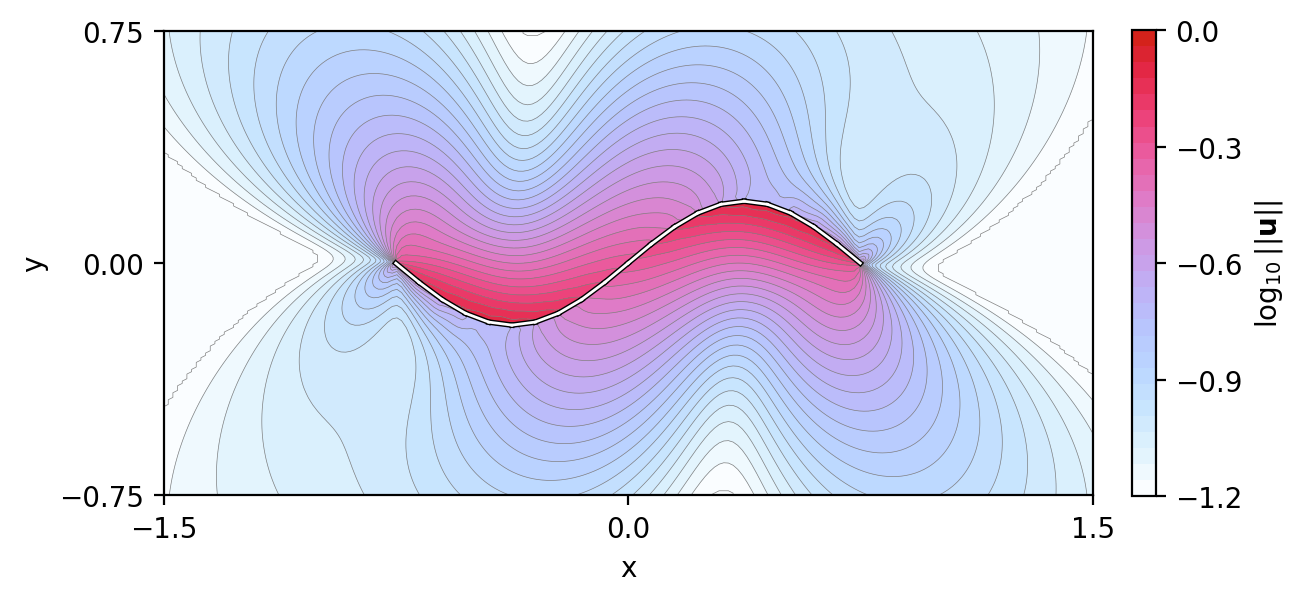

In [37]:
def plot_u_mag(x_obs, y_obs, n_obs, els, toplot, plotmax=2):
    min_val = 0
    max_val = plotmax
    min_val = -1.2
    max_val = -0.0

    n_els = np.size(els.x1)
    toplot[toplot < min_val] = min_val
    toplot[toplot > max_val] = max_val

    levels = np.linspace(min_val, max_val, 30)
    plt.contourf(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot.reshape(n_obs, n_obs),
        # cmap=cmc.bam,
        # cmap=cc.cm.CET_R1,
        cmap=cc.cm.CET_L19,
        levels=levels,
    )
    plt.colorbar(
        fraction=0.0235,
        pad=0.04,
        label="$\log_{10}||\mathbf{u}||$",
        ticks=np.linspace(min_val, max_val, 5),
        extend="both",
    )
    plt.contour(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot.reshape(n_obs, n_obs),
        linewidths=0.25,
        colors="gray",
        linestyles="-",
        levels=levels,
    )

    for i in range(n_els):
        plt.plot(
            [els.x1[i], els.x2[i]],
            [els.y1[i], els.y2[i]],
            "-k",
            linewidth=2.0,
        )
    for i in range(n_els):
        plt.plot(
            [els.x1[i], els.x2[i]],
            [els.y1[i], els.y2[i]],
            "-w",
            linewidth=1.0,
        )

    plt.xlim([np.min(x_obs), np.max(x_obs)])
    plt.ylim([np.min(y_obs), np.max(y_obs)])
    plt.xticks([-1.5, 0.0, 1.5])
    plt.yticks([-0.75, 0.0, 0.75])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()


plot_u_mag(x_obs, y_obs, n_obs, els, np.log10(u_mag), plotmax=-4)
plot_u_mag(x_obs, y_obs, n_obs, els, np.log10(u_mag_constant), plotmax=0.5)

# Plot strain energy

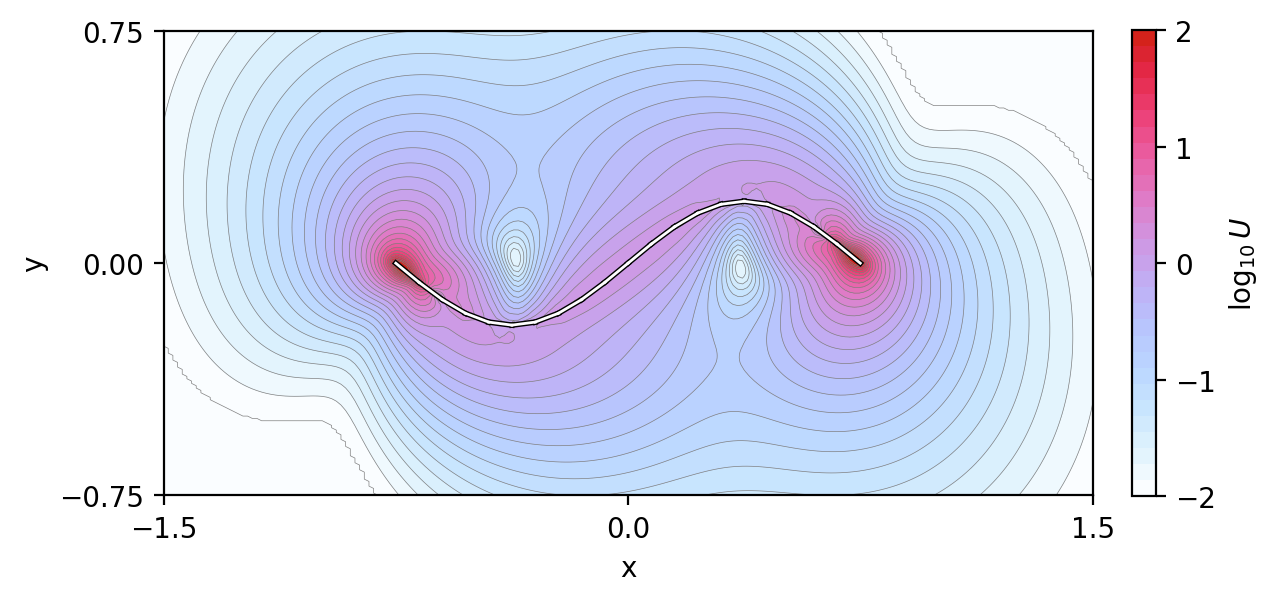

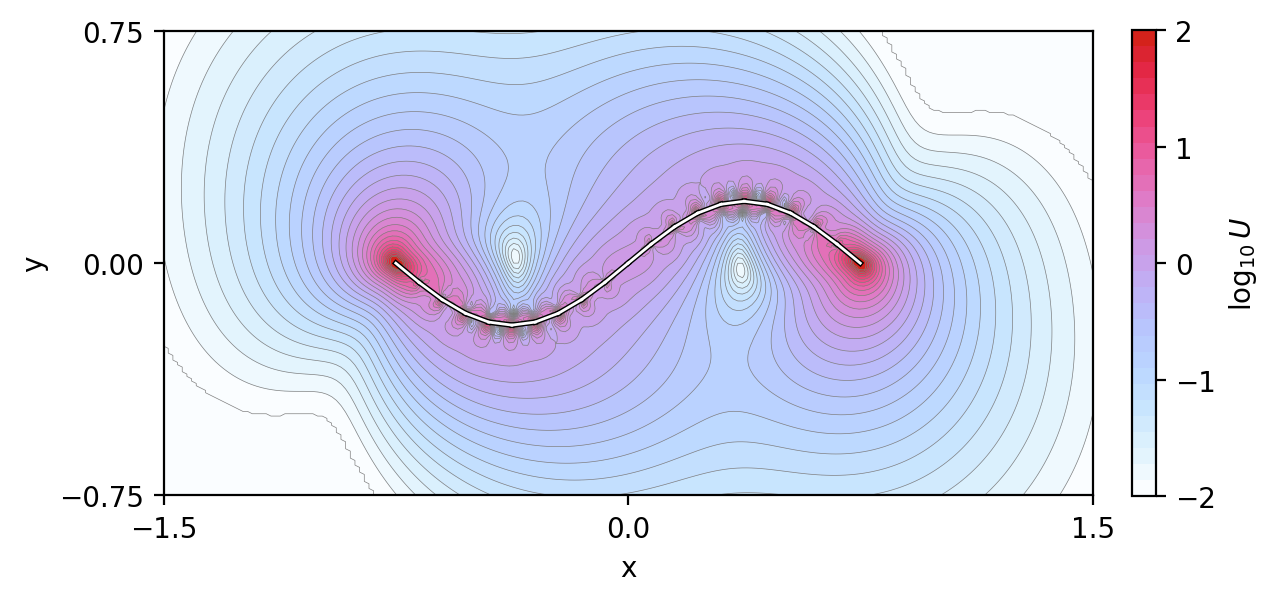

In [33]:
def plot_strain_energy(x_obs, y_obs, n_obs, els, toplot, plotmax=2):
    min_val = 0
    max_val = plotmax
    min_val = -2.0
    max_val = 2.0

    n_els = np.size(els.x1)
    toplot[toplot < min_val] = min_val
    toplot[toplot > max_val] = max_val

    levels = np.linspace(min_val, max_val, 30)
    plt.contourf(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot.reshape(n_obs, n_obs),
        # cmap=cmc.bam,
        cmap=cc.cm.CET_L19,
        # cmap=cc.cm.isolum,
        levels=levels,
    )
    plt.colorbar(
        fraction=0.0235,
        pad=0.04,
        label="$\log_{10}U$",
        ticks=np.linspace(min_val, max_val, 5),
        extend="both",
    )
    plt.contour(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot.reshape(n_obs, n_obs),
        linewidths=0.25,
        colors="gray",
        linestyles="-",
        levels=levels,
    )

    for i in range(n_els):
        plt.plot(
            [els.x1[i], els.x2[i]],
            [els.y1[i], els.y2[i]],
            "-k",
            linewidth=2.0,
        )
    for i in range(n_els):
        plt.plot(
            [els.x1[i], els.x2[i]],
            [els.y1[i], els.y2[i]],
            "-w",
            linewidth=1.0,
        )

    plt.xlim([np.min(x_obs), np.max(x_obs)])
    plt.ylim([np.min(y_obs), np.max(y_obs)])
    plt.xticks([-1.5, 0.0, 1.5])
    plt.yticks([-0.75, 0.0, 0.75])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()


plot_strain_energy(x_obs, y_obs, n_obs, els, np.log10(strain_energy), plotmax=-4)
plot_strain_energy(
    x_obs, y_obs, n_obs, els, np.log10(strain_energy_constant), plotmax=0.5
)